# Generating Validation Library for Base Editors

Needed input from user:
* path to the library fastq file
* reference sequence
    * in the example : CATACCTATGGTTTCATCCG
* reference and edited bases, plus the position of the investigated base
    * in the example A, G ad 8
* library's barcode and the relative ID
    * in the example: "GTCAGT": 1, "TAGCCT": 2, "CGGTAC": 3

In [31]:
import pandas as pd              
import itertools
import matplotlib.pyplot as plt  
import seaborn as sns            

In [32]:
# Input data
path = './src/library.fastq'

reference_region = 'CATACCTATGGTTTCATCCG'
reference_base = 'A'
edited_base    = 'G'
base_position  = 8

barcode_table = {
    "GTCAGT": 1,
    "TAGCCT": 2,
    "CGGTAC": 3
}

## Functions

### generateEditedRegions
Used to generate the list of edited sequences. These sequences are only accepted if the bases in the reference region sequence are modified according to the editor's target bases. Any "reference base" can be modified into the "edited base," where the one in the selected "base position" must always be modified.


### calculateMatrix
Used to generate the data variable where the number of edited and unedited investigated regions were observed for each combination of replicates and 4-base long PAM sequences. The replicate number is assigned by reading the bases in positions 8:14 and the reverse of -14:-8. If two different barcodes are observed, the sequence is not processed.
It invokes the functions *readFASTQ*, *reverseSequence*, and *findPAM*.


### readFASTQ
Used to read the sequences in the FASTQ file, skipping headers and other annotation lines.


### reverseSequence
Used to reverse complement input sequences.


### findPAM
Used to find the investigated region and the relative PAM sequence in a given sequence. At first, the "reference region" is searched. If not found, all the accepted edited combinations are searched. If any are found, the PAM sequence is defined by the next four bases, then the count matrix is updated by invoking *updateCounts*.
NB: Only perfect matches of either the edited or unedited region sequences are accepted by design. Potential N bases are also considered as not matches. Also, despite the rest of the sequence supposedly being constant, the region sequences are searched rather than using their coordinates to address potential indels and sequencing biases.


### updateCounts
Used to update the count data variable where the number of edited and unedited investigated regions were observed for each combination of replicates and 4-base long PAM sequences, provided by *findPAM*. Initially, N bases reported within PAM sequences were processed to add values across all four possible combinations. Resulting numbers were inconsistent with the reference replicate 1 heatmap, so it was commented out.


### conversionRate
Used to process the conversion rate by using the values generated by *calculateMatrix*.


### plotHeatmaps
Used to generate the heatmap plots whose axes are the first 2 (y) and last 2 (x) bases in the PAM, color-coded by conversion rate. The total number of PAMs is reported as well, as some high conversion rate PAMs were only observed in very few sequences, hinting at potential false positives.



In [33]:

def generateEditedRegions(reference_region, reference_base, edited_base, base_position):
    """Generate all combinations of reference region with the reference base
       replaced by the edited base except at a chosen base position."""
    
    positions = [pos for pos, char in enumerate(reference_region) if char == reference_base]
    combinations = [comb for i in range(len(positions) + 1) 
                    for comb in itertools.combinations(positions, i) if (base_position - 1) in comb]
    edited_region = []
    for comb in combinations:
        edited_seq = list(reference_region)
        for pos in comb:
            edited_seq[pos] = edited_base
        edited_region.append(''.join(edited_seq))
    return edited_region


def calculateMatrix(path, reference_region, edited_region, barcode_table):
    """Calculate the matrix counts for each PAM sequence in each replicate."""
    
    matrix_counts = {
        replicate: {pam: {'ref_count': 0, 'edit_count': 0}
                    for pam in [a+b+c+d for a in 'ATCG' for b in 'ATCG'
                                for c in 'ATCG' for d in 'ATCG']}
        for replicate in barcode_table.values()
    }

    for sequence in readFASTQ(path):
        sequence = reverseSequence(sequence)
        barcode = sequence[8:14]                      # Forward barcode
        barcoder = reverseSequence(sequence[-14:-8])  # Reverse barcode
        if barcode == barcoder:
            replicate = barcode_table.get(barcode)

            if replicate:
                pam, matrix_counts = findPAM(sequence, reference_region,
                                                 edited_region, matrix_counts, replicate)
    return matrix_counts


def readFASTQ(filename):
    """Read sequences from a FASTQ file, skipping headers and annotation."""
    
    with open(filename, 'r') as file:
        while True:
            file.readline()                # Skip IDs line
            seq = file.readline().strip()  # Read sequence line
            file.readline()                # Skip + line
            file.readline()                # Skip quality line
            if len(seq) == 0:
                break
            yield seq


def reverseSequence(seq):
    """Reverse the input DNA sequence and get its complement."""
    
    complement_dict = {'A': 'T', 
                       'T': 'A', 
                       'C': 'G', 
                       'G': 'C', 
                       'N': 'N'}
    return ''.join(complement_dict[base] for base in seq[::-1])



def findPAM(sequence, reference_region, edited_region, matrix_counts, replicate):
    """Find the PAM sequences in the given inpnut sequence"""
    
    try:
        if reference_region in sequence:
            region_index = sequence.index(reference_region)
            pam = sequence[region_index + len(reference_region): region_index + len(reference_region) + 4]
            updateCounts(pam, 'ref_count', matrix_counts, replicate)
            return pam, matrix_counts

        for edit in edited_region:   # To iterate across all possible accepted sequences
            if edit in sequence:
                region_index = sequence.index(edit)
                pam = sequence[region_index + len(edit): region_index + len(edit) + 4]
                updateCounts(pam, 'edit_count', matrix_counts, replicate)
                return pam, matrix_counts

        return None, matrix_counts

    except ValueError:
        return None, matrix_counts


def updateCounts(pam, count_type, matrix_counts, replicate):
    """Update the count for a given PAM sequence."""
    
    if 'N' not in pam:  # Account for 'N' bases by considering all possibilities. Kept, just in case
        matrix_counts[replicate][pam][count_type] += 1


def conversionRate(matrix_counts):
    """Calculate the conversion rate for each PAM across all replicates."""
    
    data = []
    for replicate, pams in matrix_counts.items():
        for pam, counts in pams.items():
            total_count = counts['ref_count'] + counts['edit_count']
            if total_count > 0:
                conversion_rate = counts['edit_count'] / total_count  
            else:
                conversion_rate = 0
            data.append([replicate, pam[:2], pam[2:], conversion_rate, total_count])

    df = pd.DataFrame(data, columns=['Replicate', 'PAM12', 'PAM34', 'Conversion Rate', 'Total Count'])
    return df


def plotHeatmaps(df, barcode_table):
    """Plot heatmaps of the conversion rates and total counts for each replicate."""
    
    all_pams = [a+b for a in 'ATCG' for b in 'ATCG']
    for replicate in barcode_table.values():
        heatmap_data = df[df['Replicate'] == replicate].pivot('PAM12', 'PAM34', 'Conversion Rate')
        total_count_data = df[df['Replicate'] == replicate].pivot('PAM12', 'PAM34', 'Total Count')
        heatmap_data = heatmap_data.reindex(index=all_pams, columns=all_pams, fill_value=0)
        total_count_data = total_count_data.reindex(index=all_pams, columns=all_pams, fill_value=0)
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=total_count_data, fmt='.0f', cmap="YlGnBu", linewidths=.5, linecolor='gray')
        plt.title(f'Replicate {replicate}')
        plt.xlabel('PAM positions 3-4')
        plt.ylabel('PAM positions 1-2')

        plt.savefig(f'heatmap_rep{replicate}.png')  # Save the heatmap as PNG
        plt.show()
        plt.close()  # Close the figure to avoid display

        





In [34]:
edited_region = generateEditedRegions(reference_region, reference_base, edited_base, base_position)
matrix_counts = calculateMatrix(path, reference_region, edited_region, barcode_table)
df = conversionRate(matrix_counts)
df

,Replicate,PAM12,PAM34,Conversion Rate,Total Count
0,1,AA,AA,0.000000,12
1,1,AA,AT,0.000000,14
2,1,AA,AC,0.000000,12
3,1,AA,AG,0.000000,10
4,1,AA,TA,0.000000,11
...,...,...,...,...,...
763,3,GG,CG,0.000000,9
764,3,GG,GA,0.333333,3
765,3,GG,GT,0.000000,2
766,3,GG,GC,0.000000,2


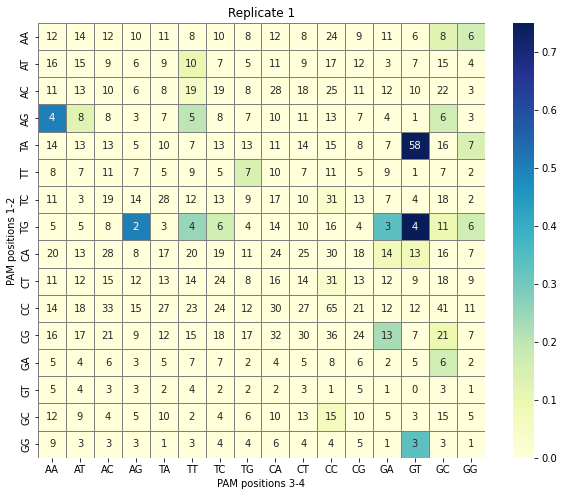

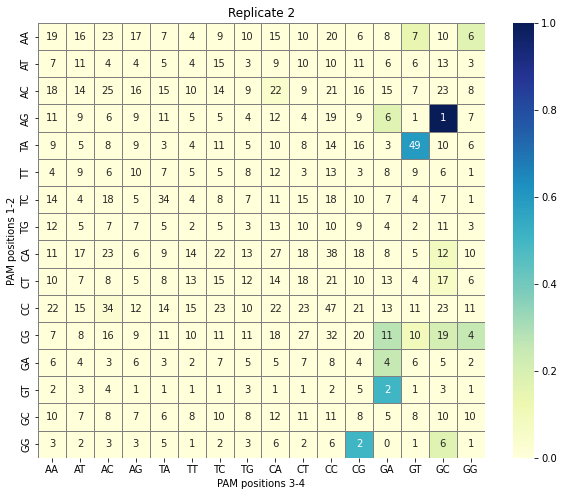

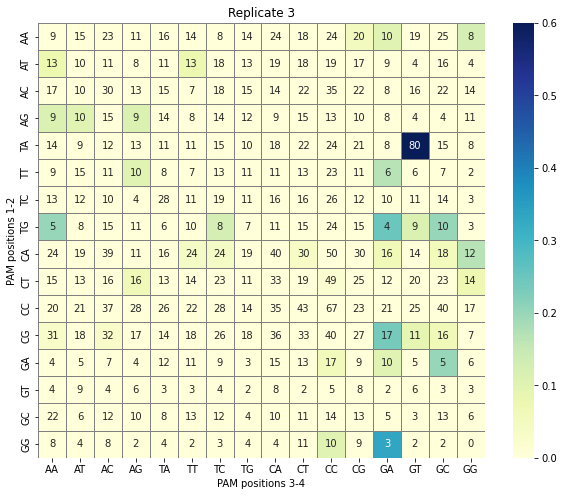

In [35]:
plotHeatmaps(df, barcode_table)

## Final comments and questions

1. Values seem not fully consistent with the ones in the replicate 1 reference heatmap. If I can take a wild guess, probably there are missing PAMS because I have only used perfect matches for barcodes, reference and edited region sequences, as it seemed relevant to only keep the "safe" ones. Is this how it is done in PAM validation? Or are sequencing biases tolerated to some extend?
2. How to deal with inconsistent forward/reverse barcodes? Are their sequences analyzed or ignored?
3. Except for barcodes, primers, edited regions and PAMs, the amplicon sequence should be constant. Of course, it is not always the case, including some potential severe errors such as indels. In these cases, should the sequece be ignored or kept, as long as the "critical" domains are unotuched?
4. What to do with N bases? Should they be considered an ureliable variable or included, to some extend?